# BuzzFeed Headline Exploratory Data Analysis

In this notebook we're going to explore what exactly makes a BuzzFeed headline and the tricks they use to grab your attention.

In [66]:
import pandas as pd
import numpy as np
import matplotlib
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# matplotlib.style.use('fivethirtyeight')
sns.set_style('ticks')
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

colors = ['#006ba6', '#0496ff', '#ffbc42', '#d81159', '#8f2d56', '#41ead4', '#ff206e']
sns.color_palette(colors)
sns.set_palette(colors)

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from langdetect import detect
from wordcloud import WordCloud
import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

stop_words = stopwords.words('english')

%config InlineBackend.figure_format = 'retina'
pd.set_option("display.max_rows", None)


print('Setup Complete.')

Setup Complete.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jordansamek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jordansamek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [67]:
data = pd.read_csv('../data/buzzfeed_headlines.csv')
print(data.shape)

# let's shuffle the dataset so everything is mixed together appropriately

data = data.sample(frac=1).reset_index().drop('index', axis=1)
data.head()

(380, 3)


,content,description,title
0,We hope you love the products we recommend! Al...,"If there are two things I love, it's looking s...",25 Stylish Yet Affordable Things From Boohoo Y...
1,"""Eventually I grew up, got married, and had a ...","""I realized I needed to change.""View Entire Po...","Former ""Nice Guys"" Shared What Made Them Chang..."
2,You all know how long we've been waiting for t...,“You all know how long we've been waiting for ...,Eve Shared A Photo Of Her Baby Bump And Announ...
3,"""I have trouble sleeping, so later, I was on t...","""My ex's family would set a set a place settin...",23 Hysterically Weird Things People Saw At The...
4,"""Two of the most effective chemical exfoliants...",I just changed one small thing but it made a b...,"Two Months Ago, I Switched One Thing In My Ski..."


## Exploring our Text Analytics

For simpler pre-processing, we'll convert the `title` column text into lowercase first.

In [68]:
def lower_title(text):
    text = str(text).lower()
    return text

data['title'] = data['title'].apply(lower_title)

data.head()

,content,description,title
0,We hope you love the products we recommend! Al...,"If there are two things I love, it's looking s...",25 stylish yet affordable things from boohoo y...
1,"""Eventually I grew up, got married, and had a ...","""I realized I needed to change.""View Entire Po...","former ""nice guys"" shared what made them chang..."
2,You all know how long we've been waiting for t...,“You all know how long we've been waiting for ...,eve shared a photo of her baby bump and announ...
3,"""I have trouble sleeping, so later, I was on t...","""My ex's family would set a set a place settin...",23 hysterically weird things people saw at the...
4,"""Two of the most effective chemical exfoliants...",I just changed one small thing but it made a b...,"two months ago, i switched one thing in my ski..."


Let's see how long each title is, on a character-based level, and maybe what the average title length is:

In [69]:
data['title_len'] = data['title'].apply(len)
data.sample(4)

,content,description,title,title_len
327,Here's what your next spooky season read shoul...,Here's what your next spooky season read shoul...,tell us your witch opinions and we'll reveal w...,95
14,"""So they had to buy a used car, but she had a ...","""One night he had me get on an airplane to get...","20 wild, lavish, or weirdly specific things ri...",98
212,The character played by Sting in Dune (1984) w...,The character played by Sting in Dune (1984) w...,"here's the cast of ""dune"" side by side with th...",66
377,"Promising review: ""I have a white tile floor a...",*cue tears of joy*View Entire Post ›,27 cleaning products reviewers swear were the ...,70


In [70]:
data['title_len'].describe()

count    380.000000
mean      87.871053
std       24.656836
min       31.000000
25%       69.000000
50%       86.000000
75%      104.000000
max      160.000000
Name: title_len, dtype: float64

Taking a look at what each title's length looks like, starting from the minimum length to the max.

In [71]:
data.groupby(['title_len'], as_index=False)['title'].max()

,title_len,title
0,31,【速報】hpvワクチン、積極的勧奨の再開を了承 厚労省の審議会
1,35,what's your nightmare period story?
2,38,トランスジェンダーは婦人科を受診しちゃいけないの？ 当事者や医師に聞いてみた
3,39,"how would you die on ""game of thrones?"""
4,42,these random questions reveal if you floss
5,43,自民党「影の幹事長」がdappiへの関与を否定。群馬の村で見えた“親族のつながり“とは
6,47,17 actors who i'm convinced could play any role
7,48,rate these creamy foods and we'll guess your age
8,49,36 products that might help solve your sleep woes
9,50,these 90s rom-coms will 100% make your life be...


We should probably remove the 3 titles that aren't English, just for the sake of consistency of our values that we'll eventually be processing and putting into our ML model.

In [72]:
def detect_lang(txt):
    try:
        return detect(txt)
    except:
        return np.nan
    
data['language'] = data.title.apply(detect_lang)

In [73]:
data = data[data.language == "en"]
data.groupby(['title_len'], as_index=False)['title'].max()

,title_len,title
0,35,what's your nightmare period story?
1,38,just 34 very nice things for your home
2,39,"how would you die on ""game of thrones?"""
3,42,these random questions reveal if you floss
4,47,17 actors who i'm convinced could play any role
5,48,rate these creamy foods and we'll guess your age
6,49,36 products that might help solve your sleep woes
7,50,these 90s rom-coms will 100% make your life be...
8,51,these 20 high fashion dogs dress better than y...
9,52,what’s it like to have never been in a relatio...


In [74]:
data = data.drop('language', axis=1)

In [75]:
data.head()

,content,description,title,title_len
0,We hope you love the products we recommend! Al...,"If there are two things I love, it's looking s...",25 stylish yet affordable things from boohoo y...,86
1,"""Eventually I grew up, got married, and had a ...","""I realized I needed to change.""View Entire Po...","former ""nice guys"" shared what made them chang...",111
2,You all know how long we've been waiting for t...,“You all know how long we've been waiting for ...,eve shared a photo of her baby bump and announ...,89
3,"""I have trouble sleeping, so later, I was on t...","""My ex's family would set a set a place settin...",23 hysterically weird things people saw at the...,103
4,"""Two of the most effective chemical exfoliants...",I just changed one small thing but it made a b...,"two months ago, i switched one thing in my ski...",98


Before cleaning our `title` column to be put into an ML pipeline, let's just do some basic text analytics to get a sense of what each title consists of.

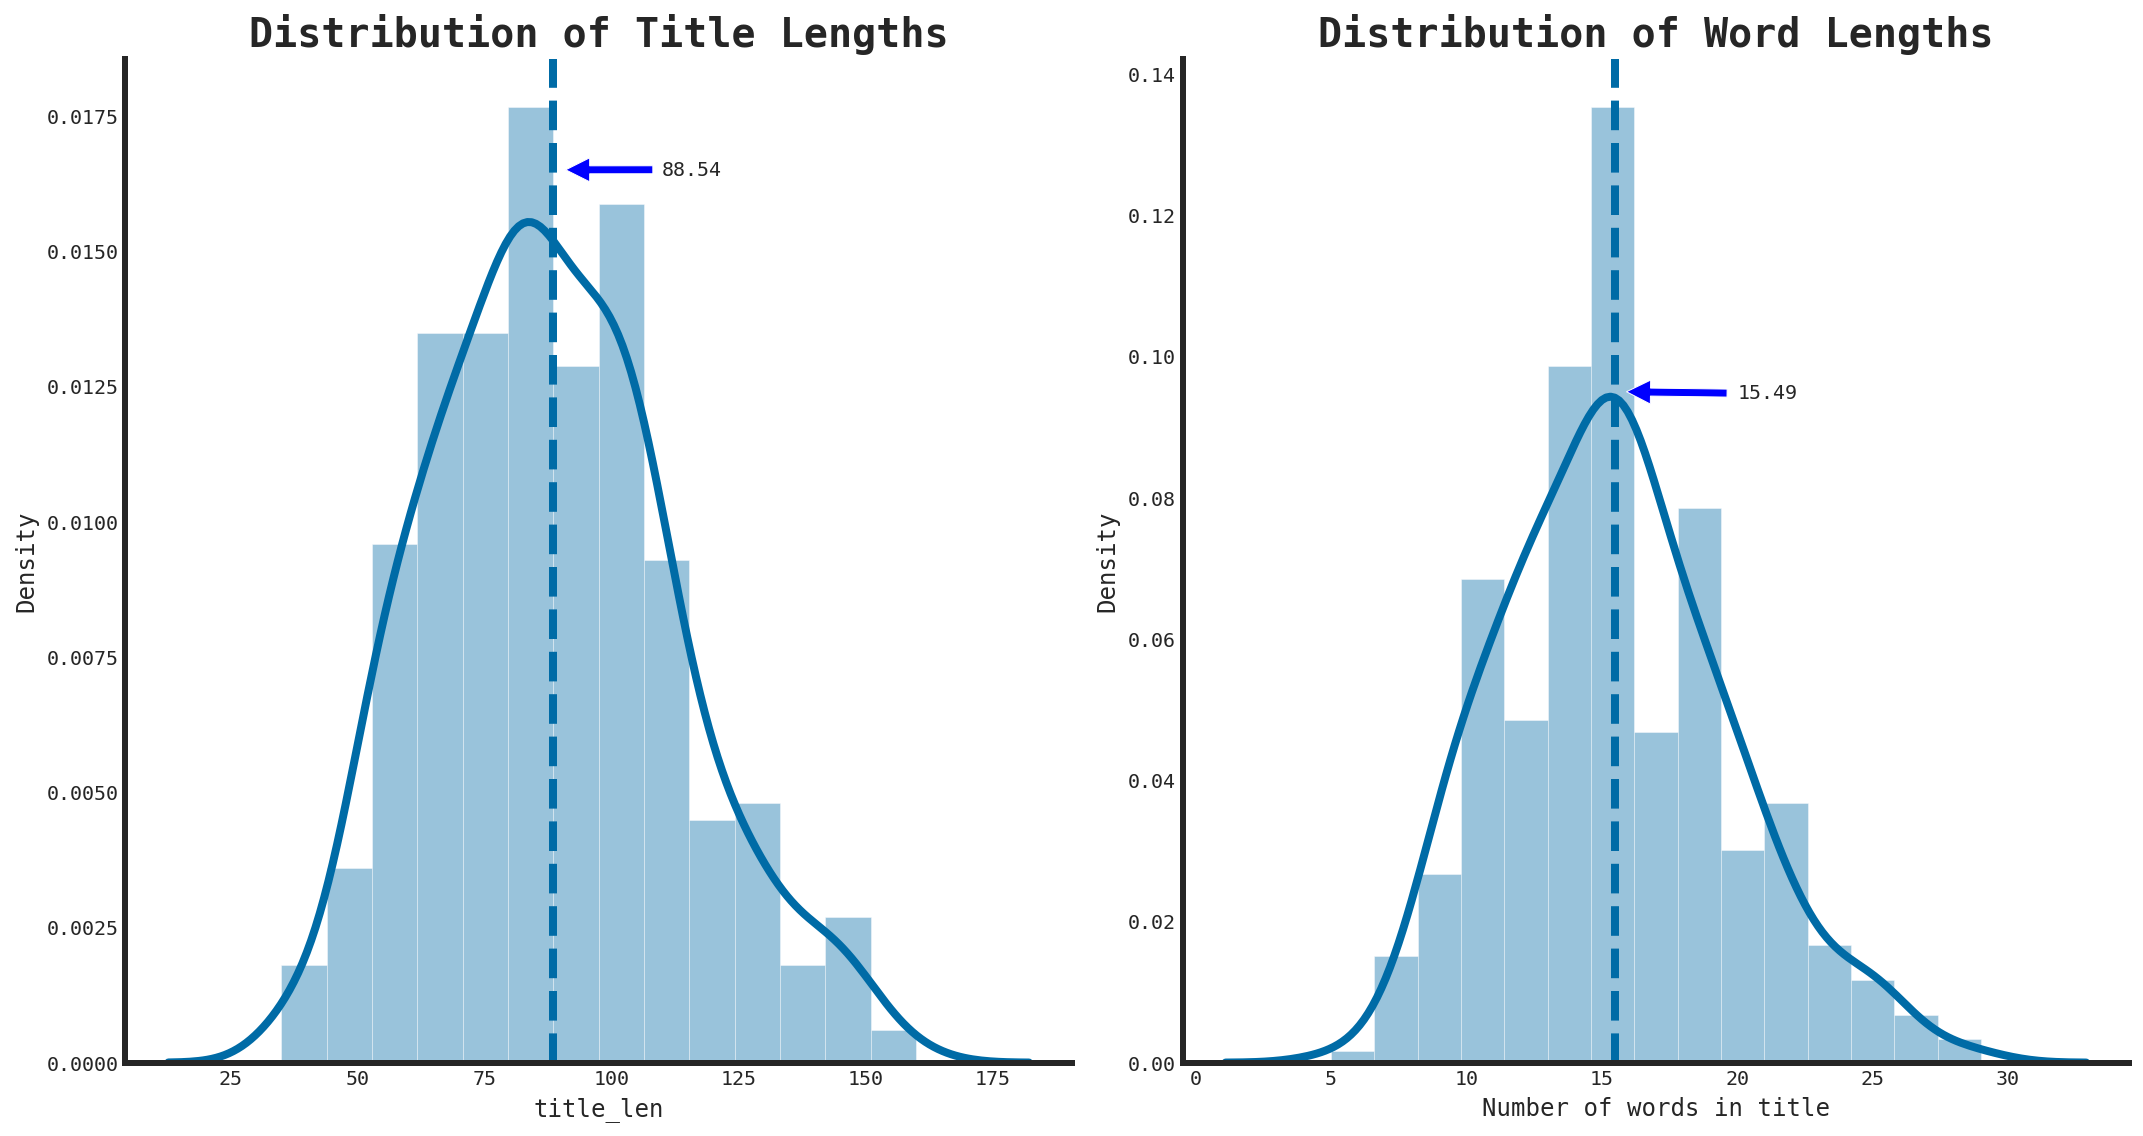

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

plt.subplot(1, 2, 1)
sns.distplot(data['title_len']).set_title('Distribution of Title Lengths', fontsize=20, fontweight='bold')
plt.axvline(np.array(data['title_len'].mean()), ls='dashed')
plt.annotate(round(data['title_len'].mean(),2), xy=(90, 0.0165), xycoords='data', xytext=(110, 0.0164),
             arrowprops=dict(facecolor='blue', shrink=0.05))


title_word_len = data['title'].str.split().map(lambda x: len(x))
word_len_mean = round(title_word_len.mean(), 2)

plt.subplot(1, 2, 2)
sns.distplot(title_word_len).set_title('Distribution of Word Lengths', fontsize=20, fontweight='bold')
plt.axvline(word_len_mean, ls='dashed')
plt.annotate(word_len_mean, xy=(15.7, 0.095), xycoords='data', xytext=(20, 0.094),
             arrowprops=dict(facecolor='blue', shrink=0.05))
plt.xlabel("Number of words in title")

# ax.grid(color='black', linestyle=':', axis='y', zorder=0, dashes=(6, 6))
# ax.set_ylabel('')

plt.tight_layout()
plt.show();

In [78]:
min_title_words = data.title.str.split().map(lambda x: len(x)).min()
max_title_words = data.title.str.split().map(lambda x: len(x)).max()

print(f"The minimum amount of words in our titles is {min_title_words}")
print(f"The maxmimu amount of words in our titles is {max_title_words}")

The minimum amount of words in our titles is 5
The maxmimu amount of words in our titles is 29


If anyone has ever seen any sort of clickbait headlines (which BuzzFeed apparently denies their headlines are clickbait), they've most likely noticed it probably has an odd number thrown in there like "27 Things You Shouldn't Do on a First Date!!" to grab your attention. This type of headline works in many different ways, but one major way is because we humans love lists, especially numbered lists. So let's check out how many headlines of BuzzFeed's contain numbers in them:

In [79]:
num_in_headline_count = 0
no_num_headline_count = 0
for line in data.title:
    if bool(re.search('\d+', line)) == True:
        num_in_headline_count += 1
    else:
        no_num_headline_count += 1
    

In [108]:
# Headlines with numbers - {num_in_headline_count}
# Headlines without numbers - {no_num_headline_count}
num_in_headline_count, no_num_headline_count

(179, 195)

In [127]:
headline_nums = {'num_in_headline_count': num_in_headline_count, 'no_num_headline_count': no_num_headline_count}
headline_numbers = pd.DataFrame(headline_nums, index=[0])

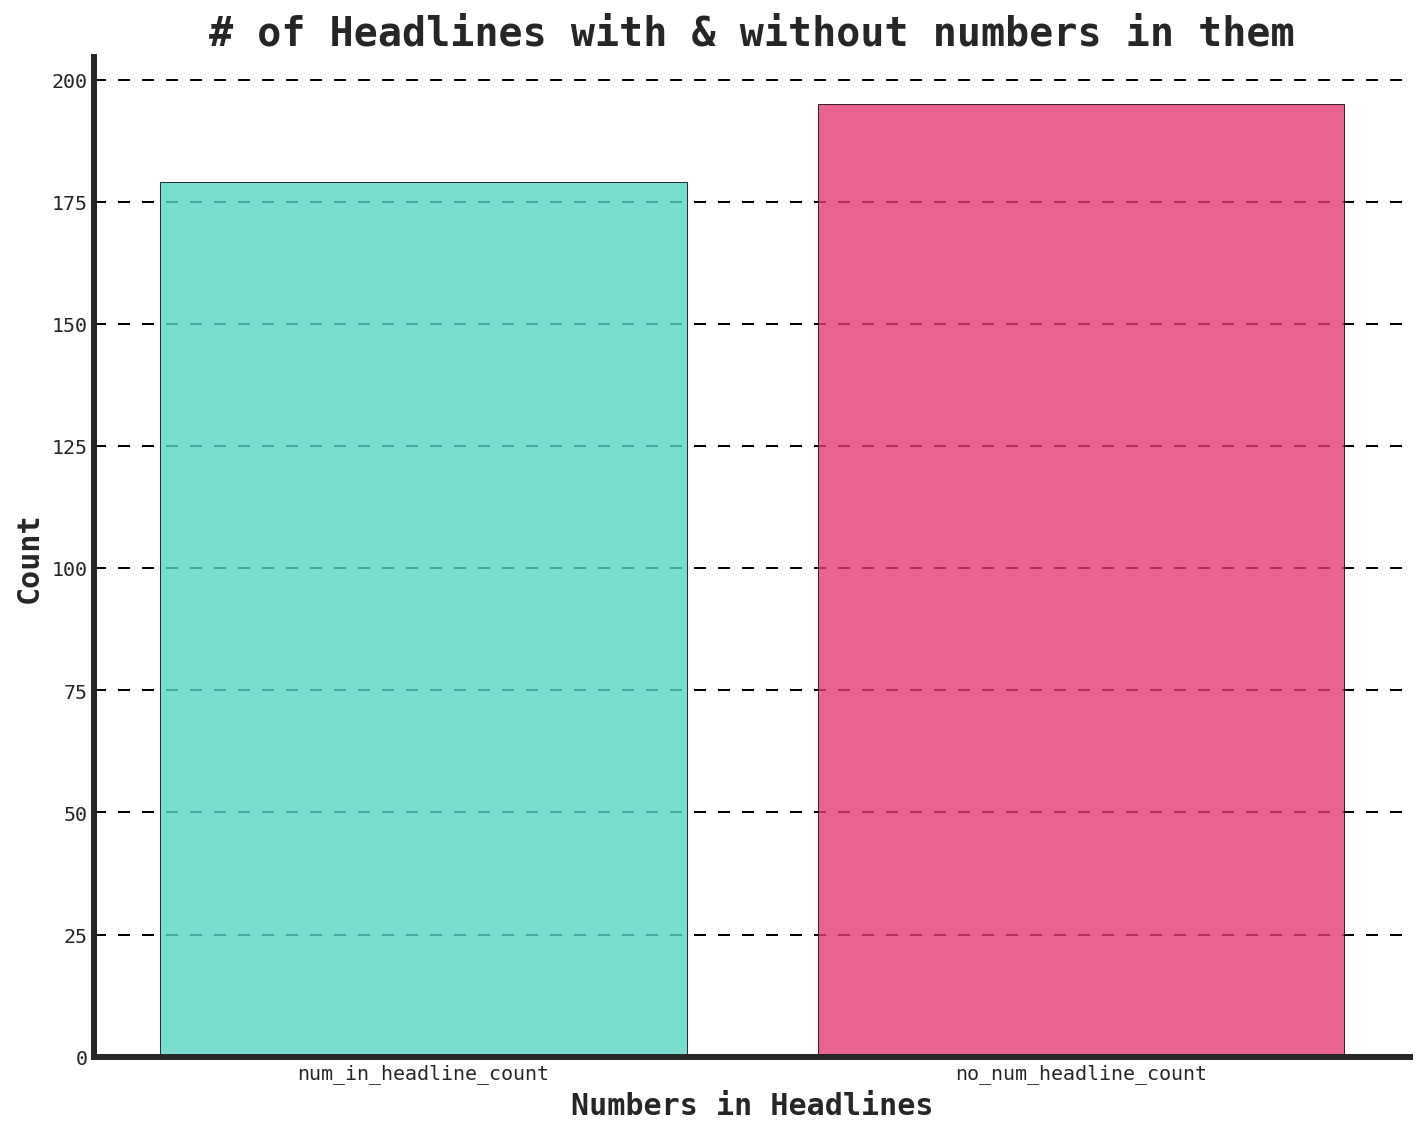

In [134]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=headline_numbers, ax=ax, alpha=0.8, zorder=2, palette=colors[-2:], edgecolor='black')
ax.set_title("# of Headlines with & without numbers in them", fontweight='bold', fontsize=20)
ax.grid(color='black', linestyle=':', axis='y', zorder=0, dashes=(6, 6))
ax.set_xlabel("Numbers in Headlines", fontweight='bold', fontsize=15)
ax.set_ylabel("Count", fontweight='bold', fontsize=15)
plt.tight_layout()
plt.show();

My guess would have been that there were more headlines with numbers in them than without, but as we can see the headlines are relatively balanced when it comes to titles containing numbers. Even more surprisingly, headlines without numbers have the slight edge over headlines that include digits.

For simplicity sake, let's cut down our data so that it just includes our title text and our text length. We can come back later and do some analysis on the `content` and `description` features of our original dataset, but for now it will be easier to just work with our necessary features.

In [17]:
title_df = data[['title', 'title_len']]
title_df.sample(5)

,title,title_len
139,home chef’s latest deal is served: $110 off yo...,66
325,"dakota johnson reflected on how ""fifty shades ...",149
77,"here's where you have seen the cast of ""hawkey...",55
200,21 famous men who seriously deserve to be the ...,120
257,people are sharing the most paranormal thing t...,114


Remove stopwords from the titles and then we'll make a quick wordcloud to visualize popular words before we fully clean the text for other NLP analysis.

In [18]:
title_df['clean_title'] = title_df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [19]:
title_df.sample(5)

,title,title_len,clean_title
355,45 american holidays that we should absolutely...,68,45 american holidays absolutely get day
344,26 things people said as children that are min...,83,"26 things people said children mind-blowing, a..."
291,51 film and tv scenes that are sexy as heck wi...,67,51 film tv scenes sexy heck without ounce sex
287,this person is going viral for roasting people...,143,person going viral roasting people visit popul...
44,top 5 digital marketing strategies that worked...,56,top 5 digital marketing strategies worked tesla


In [20]:
clean_title_vals = title_df['clean_title'].values
print(str(clean_title_vals))

['21 things publix workers absolutely hate 4 things absolutely love'
 '25 "facts" everyone agrees true are...wait minute...completely false'
 '14 haunting real-life facts ever heard'
 'here\'s seen cast "locke & key"'
 '15 things entitled customers signal servers tip well, annoying terrible'
 '36 products might help solve sleep woes'
 'men sharing annoying thing guy, answers honestly place'
 'author "sex city" shared honest take show\'s un-feminist ending'
 'princess mako japan gave royal title marry "commoner" fiancé, kei komuro, story deserves movie asap'
 'tom holland shared another tribute zendaya instagram, made history cfda fashion awards'
 'skeet ulrich admitted know "scream" comedy started shooting'
 '22 self-care products parents want treat'
 'there\'s "twin peaks" resident us all, one you?'
 'misconceptions open relationships?'
 '15 celebrities use stage names, like 30% people know real names'
 'stairs lead nowhere, 17 photos sit right'
 'ferrell says turned $29 million "elf"

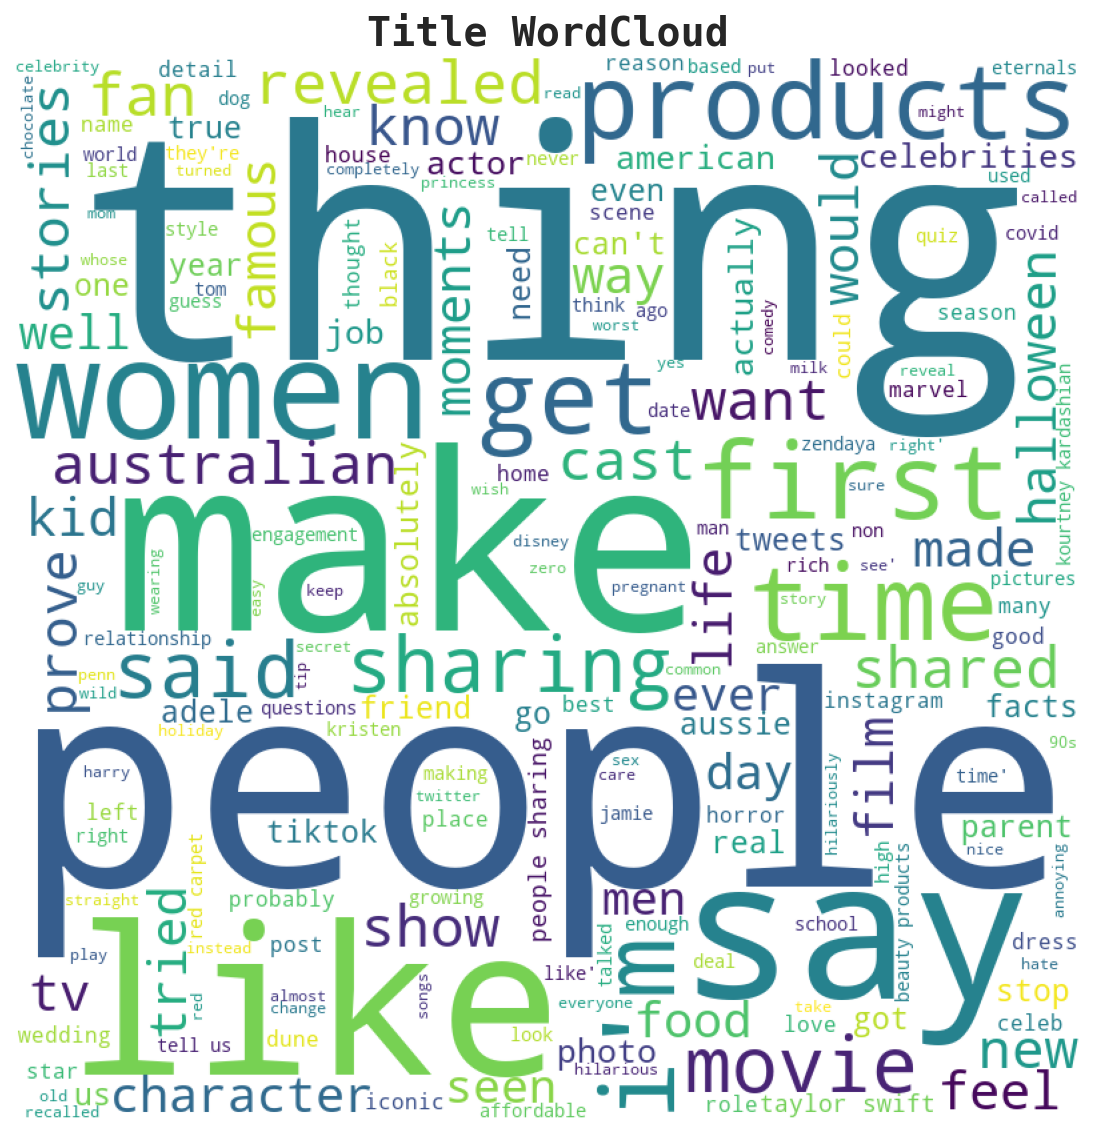

In [138]:
clean_title_vals = title_df['clean_title'].values

title_wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=stop_words,
                      min_font_size=8).generate(str(clean_title_vals))

plt.figure(figsize=(10, 8))
plt.imshow(title_wordcloud)
plt.title("Title WordCloud", size=20, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show();

Basically the 3 most popular words that BuzzFeed uses in their headlines are "thing", "people", and "make". We don't need to know the context in which they use them just yet, but let's see if these 3 popular words translate into what their top n-gram combinations are...

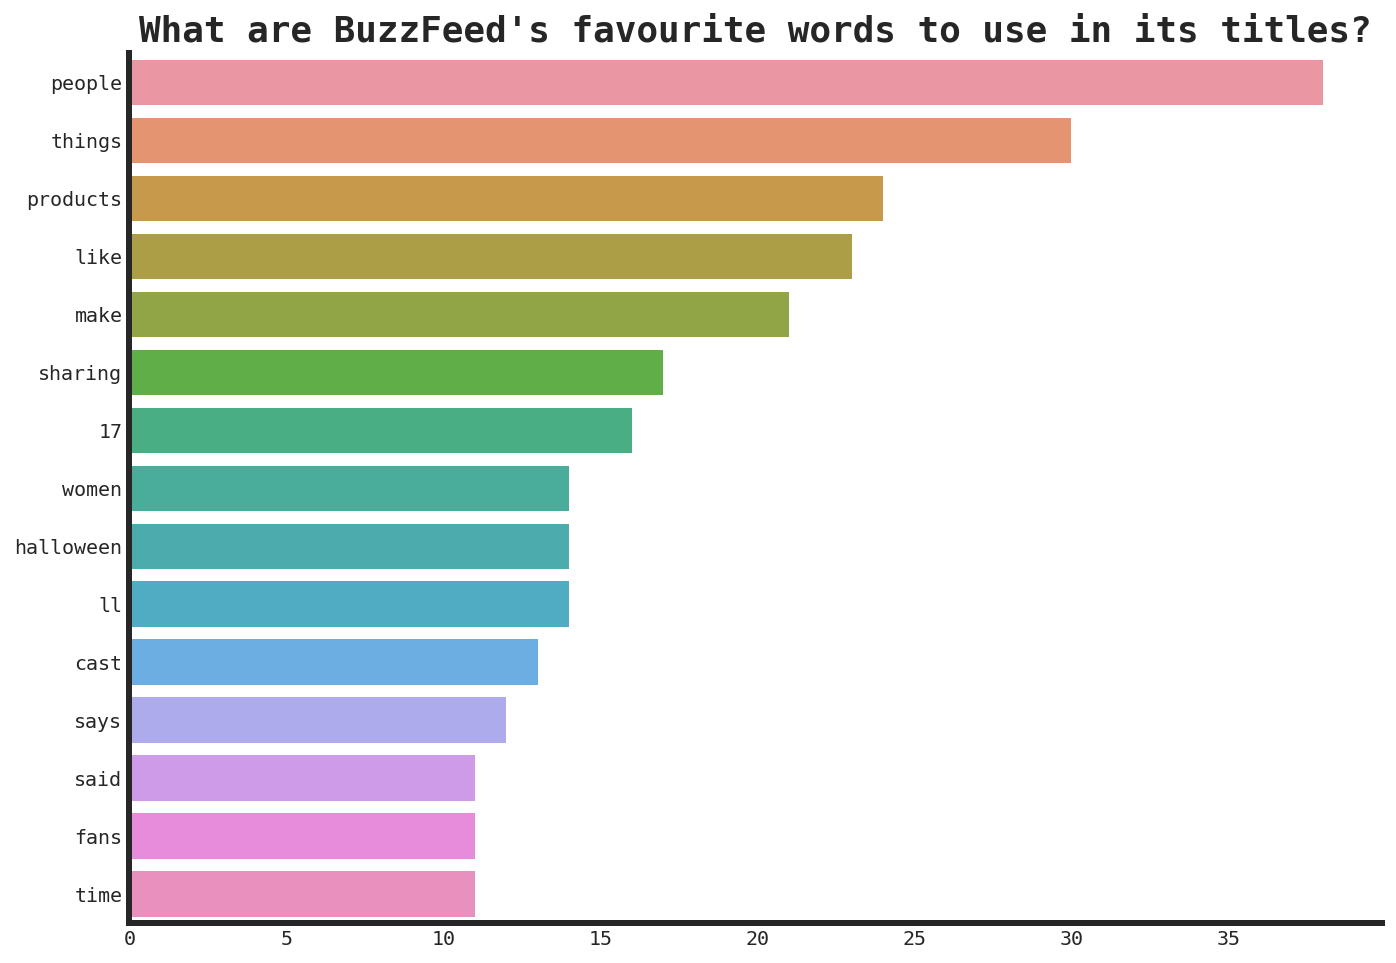

In [137]:
# n-gram visualizations

def get_ngrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bow = vec.transform(corpus)
    sum_words = bow.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:15]

top_n_unigrams = get_ngrams(title_df['clean_title'], 1)
x, y = map(list, zip(*top_n_unigrams))
plt.figure(figsize=(10, 8))
sns.barplot(x=y, y=x)
plt.title("What are BuzzFeed's favourite words to use in its titles?", size=18, fontweight='bold')
plt.show();

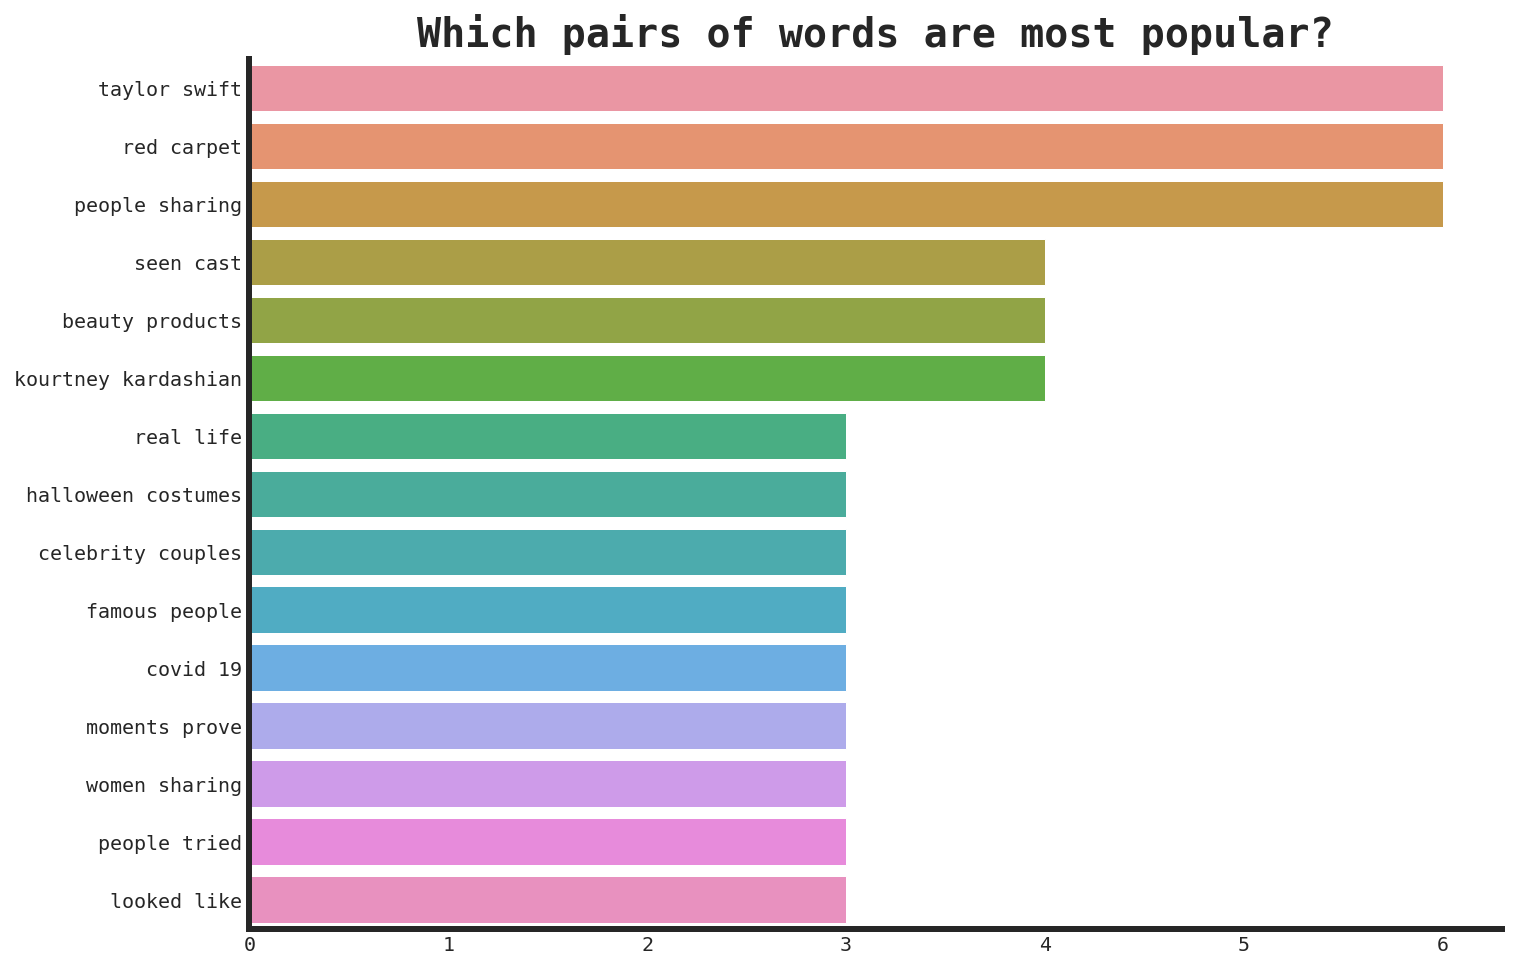

In [111]:
top_n_bigrams = get_ngrams(title_df['clean_title'], 2)
x, y = map(list, zip(*top_n_bigrams))
plt.figure(figsize=(10, 8))
sns.barplot(x=y, y=x)
plt.title("Which pairs of words are most popular?", size=20, fontweight='bold')
plt.show();

These pairings of words are a bit funny based off the time that they were collected in. We can obviously pick out which sort of topics BuzzFeed was covering at the time of scraping: Taylor Swift was re-releasing another album, there was obviously some sort of Kardashian drama going on, and it was around October that I collected the headlines.

We'll move on and start to do a bit of topic modeling with a cool library called `pyLDAvis`. First we'll process the text data a little bit more so the new topic modeling library can handle what we throw at it. We'll create a new function that will wrap all of our cleaning techniques into one:

In [112]:
def preprocess(df):
    corpus = []
    stem = PorterStemmer()
    lem = WordNetLemmatizer()
    for headline in title_df['clean_title']:
        words = [w for w in word_tokenize(headline) if (w not in stop_words)]
        words = [lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

corpus = preprocess(title_df)

In [113]:
# create a Bag-of-Words model using gensim
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [116]:
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                       num_topics=3,
                                       id2word=dic,
                                       passes=10,
                                       workers=2,
                                       random_state=2021)
lda_model.show_topics()

[(0,
  '0.013*"thing" + 0.008*"product" + 0.005*"people" + 0.005*"said" + 0.004*"show" + 0.004*"halloween" + 0.004*"\'ll" + 0.004*"absolutely" + 0.003*"quiz" + 0.003*"photo"'),
 (1,
  '0.006*"make" + 0.005*"cast" + 0.005*"n\'t" + 0.004*"product" + 0.004*"sharing" + 0.004*"story" + 0.004*"thing" + 0.004*"character" + 0.004*"one" + 0.004*"say"'),
 (2,
  '0.017*"people" + 0.011*"time" + 0.009*"like" + 0.008*"woman" + 0.007*"celebrity" + 0.006*"thing" + 0.006*"made" + 0.005*"say" + 0.005*"sharing" + 0.005*"know"')]

In [176]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
vis = gensimvis.prepare(lda_model, bow_corpus, dic)
pyLDAvis.display(vis)

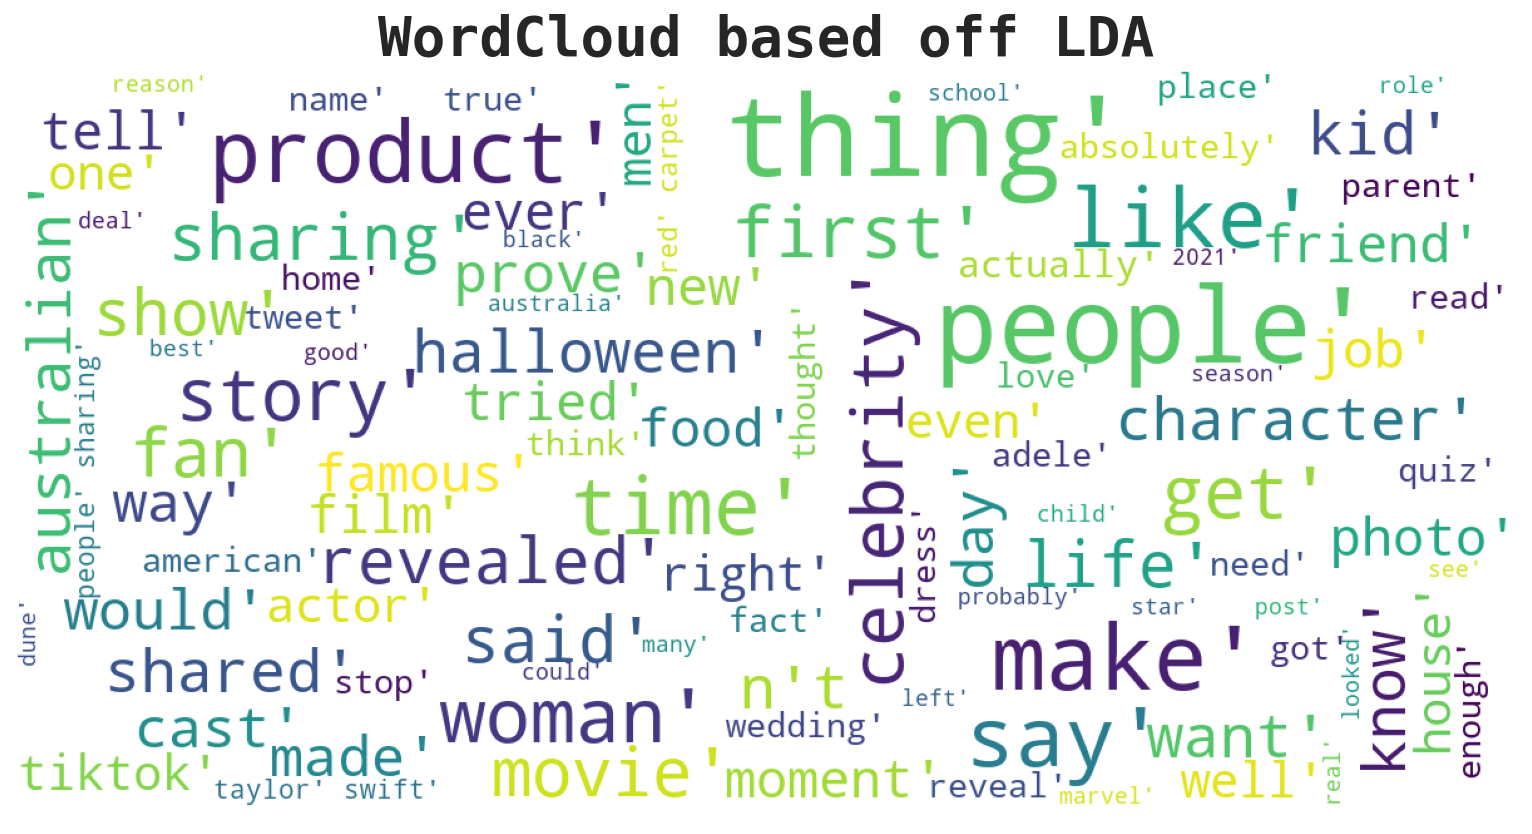

In [118]:
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stop_words,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=42
    )
    wordcloud = wordcloud.generate(str(data))
    
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.title("WordCloud based off LDA", size=28, fontweight='bold')
    plt.show();
    
show_wordcloud(corpus)

Moving on to use the TextBlob library to calculate the polarity and sentiment of the headlines.

In [119]:
from textblob import TextBlob

In [120]:
def polarity(text):
    # calculating polarity scores of our headlines
    # will give a score between -1.0 and 1.0
    return TextBlob(text).sentiment.polarity

title_df['polarity_score'] = title_df['title'].apply(lambda x: polarity(x))

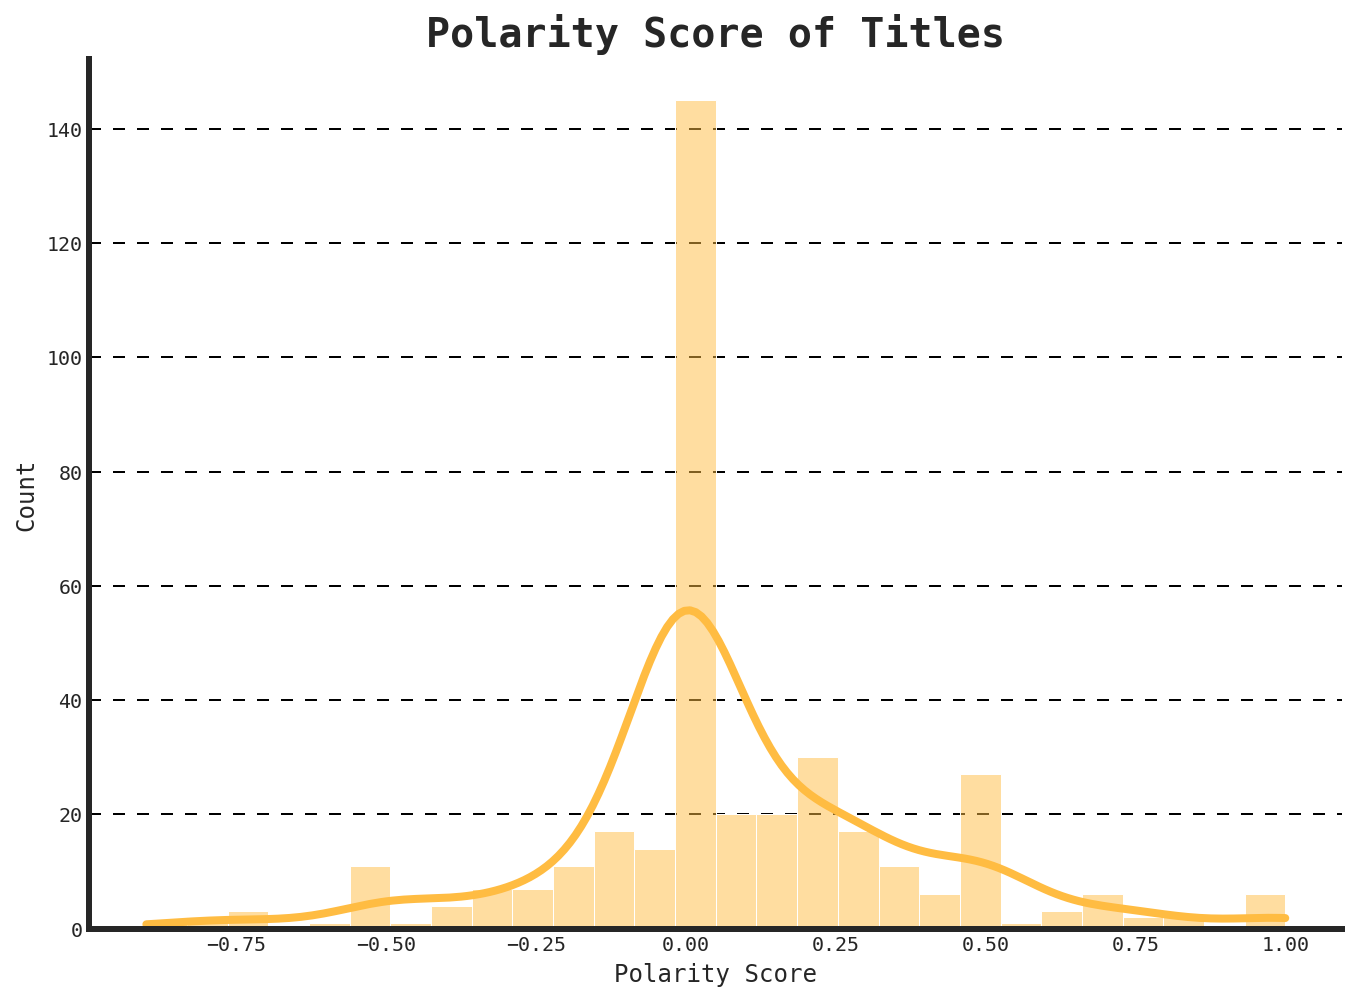

In [140]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.histplot(title_df.polarity_score, kde=True, color=colors[2])
ax.grid(color='black', linestyle=':', axis='y', zorder=0, dashes=(6, 6))
ax.set_title("Polarity Score of Titles", size=20, fontweight='bold')
ax.set_xlabel("Polarity Score")
plt.show();

In [122]:
title_df['polarity_score'].describe()

count    375.000000
mean       0.081467
std        0.293888
min       -0.900000
25%        0.000000
50%        0.000000
75%        0.246429
max        1.000000
Name: polarity_score, dtype: float64

We can see that our mean polarity score is around 0.08 which is a very low score, meaning that our headlines, on average, are quite neutral and maybe even slightly more positive in their sentiment. BuzzFeed isn't generally a news outlet that gets too political, but we can also note that my period of collection of the headlines wasn't any significant point in time so there shouldn't be many polarizing topics unless BuzzFeed editors are feeling frisky. We'll have a better conclusion once we calculate the sentiments and visualize them.

So we've got polarity scores to quantitatively show what our headlines are like, but let's classify those scores as either positive, negative or neutral sentiment. We'll do this by creating a function that specifies a threshold, and if the scores are above, below, or equal to the threshold then we bin them into their corresponding category.

In [123]:
def sentiment(x):
    if x < 0:
        return 'negative'
    elif x == 0:
        return 'neutral'
    else:
        return 'positive'
    
title_df['sentiment'] = title_df['polarity_score'].apply(lambda x: sentiment(x))

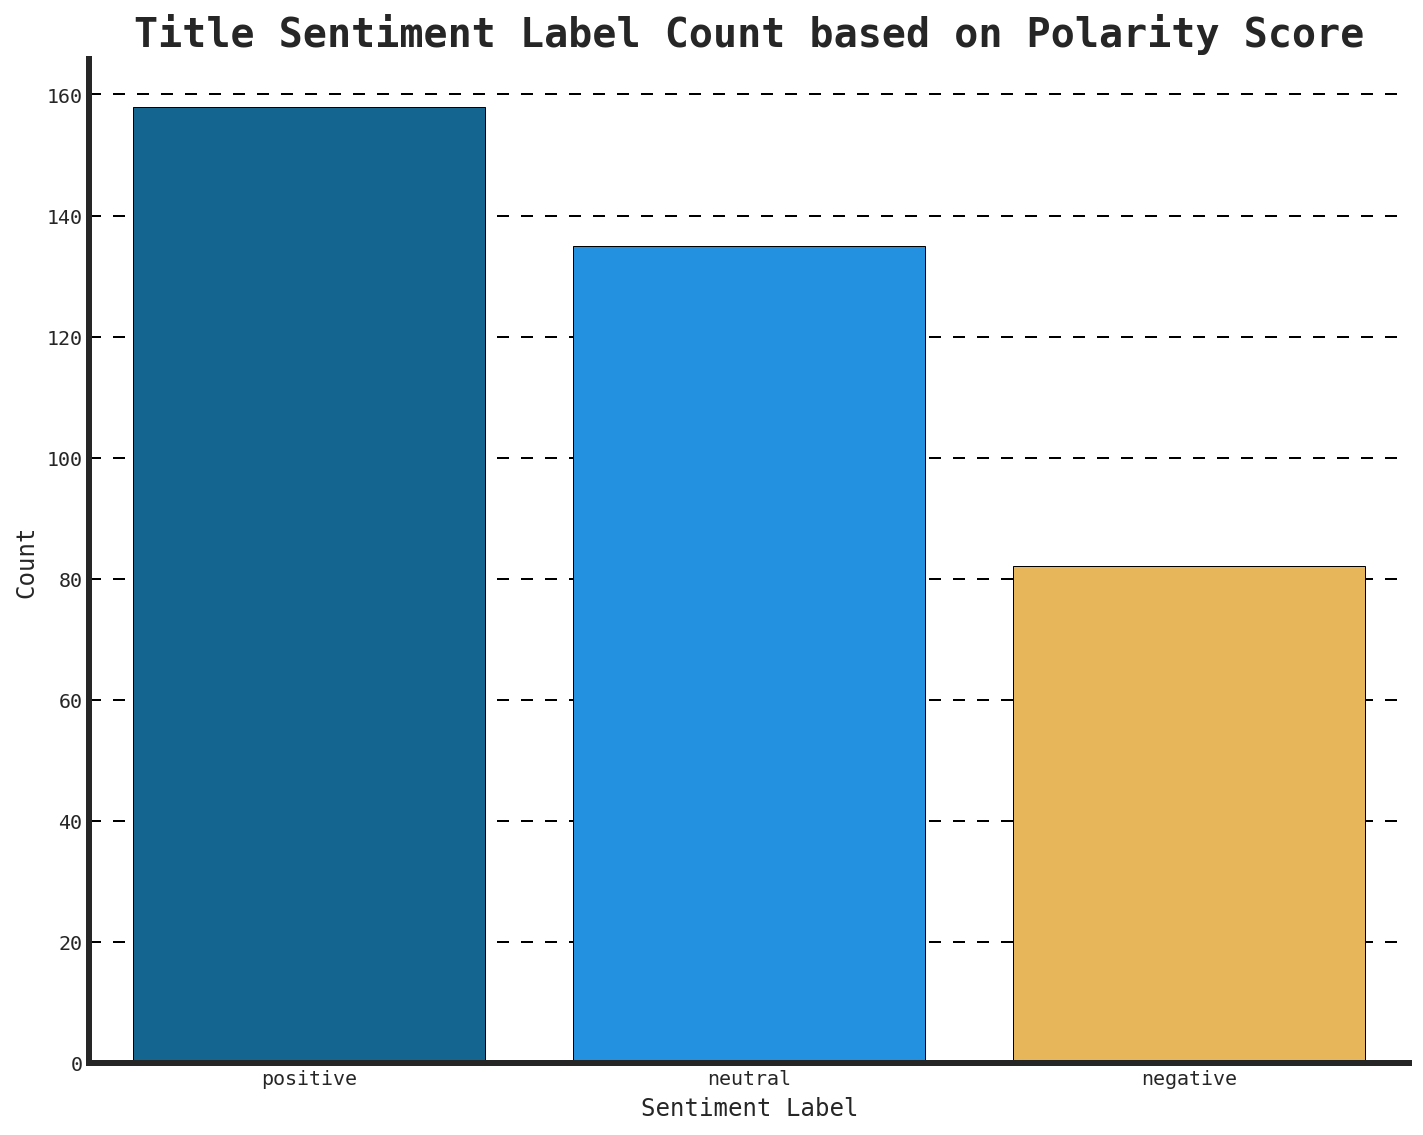

In [142]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(title_df.sentiment.value_counts().index,
            title_df.sentiment.value_counts(), edgecolor='black')
ax.set_title("Title Sentiment Label Count based on Polarity Score", size=20, fontweight='bold')
ax.set_xlabel("Sentiment Label")
ax.set_ylabel("Count")
ax.grid(color='black', linestyle=':', axis='y', zorder=0, dashes=(6, 6))
plt.tight_layout()
plt.show();

In [146]:
pct_sent = round((title_df.sentiment.value_counts() / (len(title_df)))*100, 2)
print(pct_sent)

positive    42.13
neutral     36.00
negative    21.87
Name: sentiment, dtype: float64


Let's take a look at a few headlines from each sentiment category...

In [147]:
pos_headlines = title_df[title_df['sentiment'] == 'positive']['title']
print(pos_headlines.sample(3).tolist())

['adele recalled feeling ashamed during her divorce from simon konecki: "you feel like you didn\'t do a good job"', "people look down on these things because women like them, and it's honestly so messed up", '36 products that will make your household run more seamlessly']


In [148]:
neu_headlines = title_df[title_df['sentiment'] == 'neutral']['title']
print(neu_headlines.sample(3).tolist())

['tom holland shared another tribute to zendaya on instagram, after she made history at the cfda fashion awards', 'a$ap rocky stopped his show and demanded fallen fans be picked up in a resurfaced video', 'lady gaga fans are defending her accent in "house of gucci" after the film’s dialect coach criticized it']


In [149]:
neg_headlines = title_df[title_df['sentiment'] == 'negative']['title']
print(neg_headlines.sample(3).tolist())

['45 everyday things that i thought were way cheaper before i actually had to buy them myself', '55 awkward and kinda awful early 2000s trends that are poised to make a comeback whether you like it or not', 'what questions does "squid game" season two need to answer?']


We see some interesting headlines when we print out the results. Some even don't make sense being in the category that they're in. This could be due to the fact that some sentiment analysis techniques/libraries aren't great at detecting negative sentiments. One library that works pretty well at detecting negative sentiments is the VADER library. We can import it via `nltk` and work from there.

In [150]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

def vader_score(sent):
    ss = sia.polarity_scores(sent)
    
    return np.argmax(list(ss.values())[::-1])

title_df['polarity'] = title_df['title'].apply(lambda x: vader_score(x))
polarity = title_df['polarity'].replace({0:'neg', 2:'neu', 3:'pos'})

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jordansamek/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


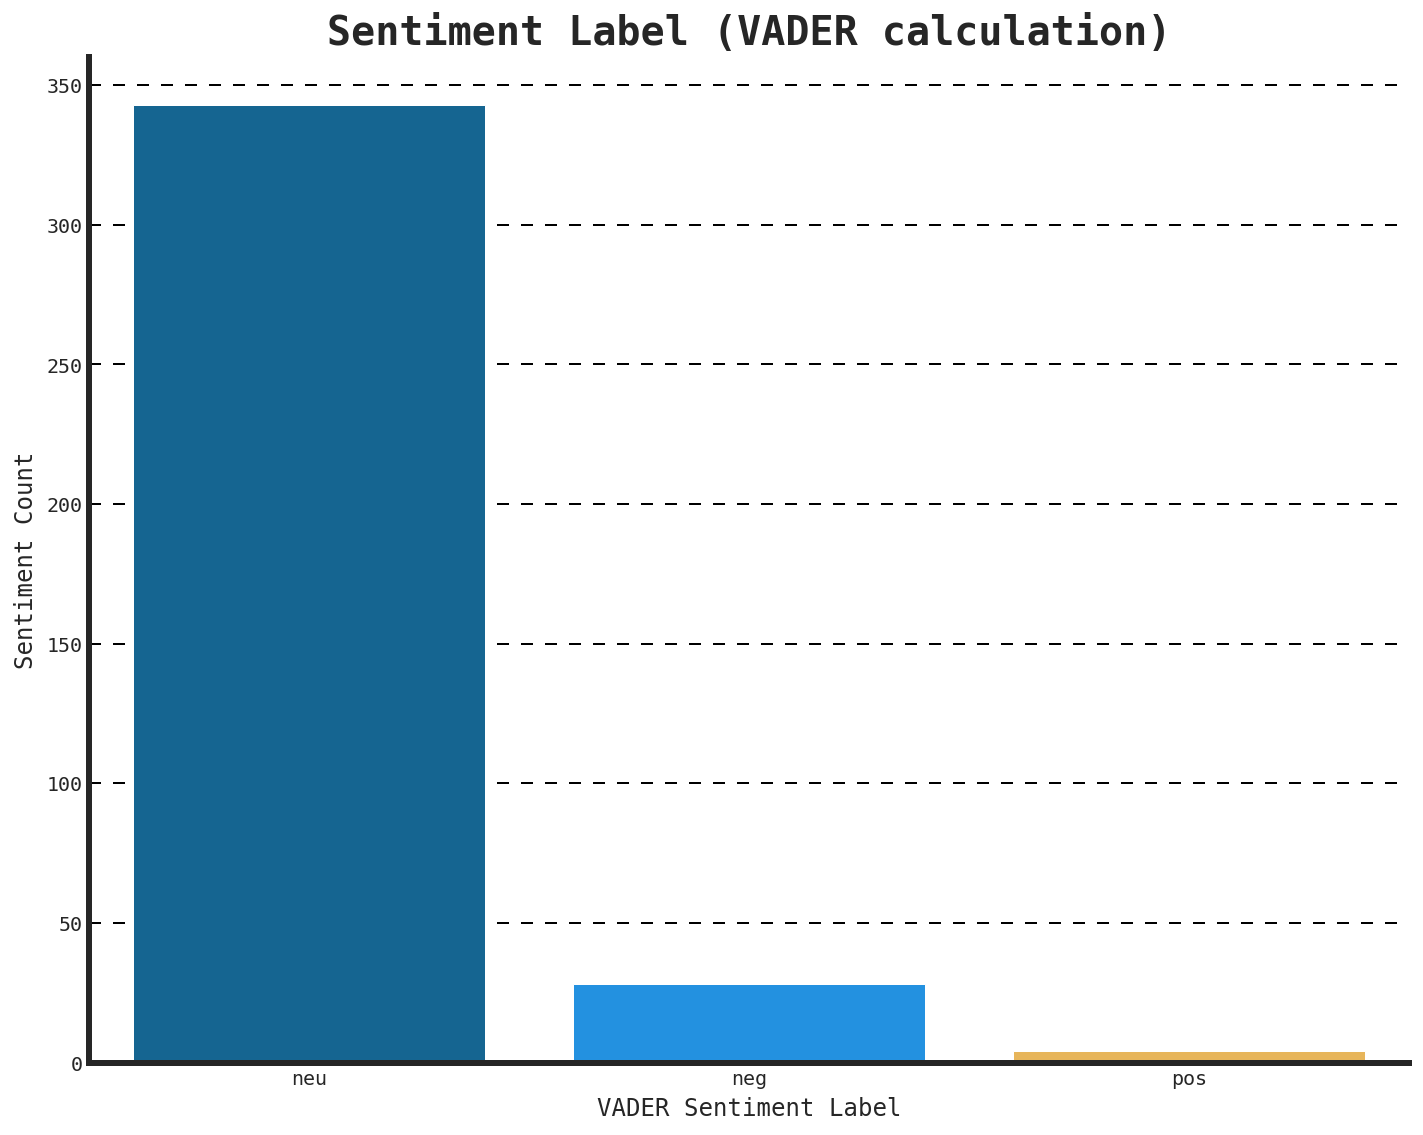

In [152]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(polarity.value_counts().index,
            polarity.value_counts())
ax.set_title("Sentiment Label (VADER calculation)", size=20, fontweight='bold')
ax.set_xlabel("VADER Sentiment Label")
ax.set_ylabel("Sentiment Count")
ax.grid(color='black', linestyle=':', axis='y', zorder=0, dashes=(6, 6))
plt.tight_layout()
plt.show();

In [153]:
title_df['polarity'].value_counts()

2    343
0     28
3      4
Name: polarity, dtype: int64

In [154]:
title_df['polarity'].describe()

count    375.000000
mean       1.861333
std        0.539333
min        0.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        3.000000
Name: polarity, dtype: float64

In [155]:
def vader_sentiment(score):
    emotion = ""
    if score == 3.0:
        emotion = "positive"
    elif score == 2.0:
        emotion = "neutral"
    else:
        emotion = "negative"
    return emotion

In [156]:
title_df['vader_sentiment'] = title_df['polarity'].apply(lambda x: vader_sentiment(x))
title_df['vader_sentiment'].value_counts()

neutral     343
negative     28
positive      4
Name: vader_sentiment, dtype: int64

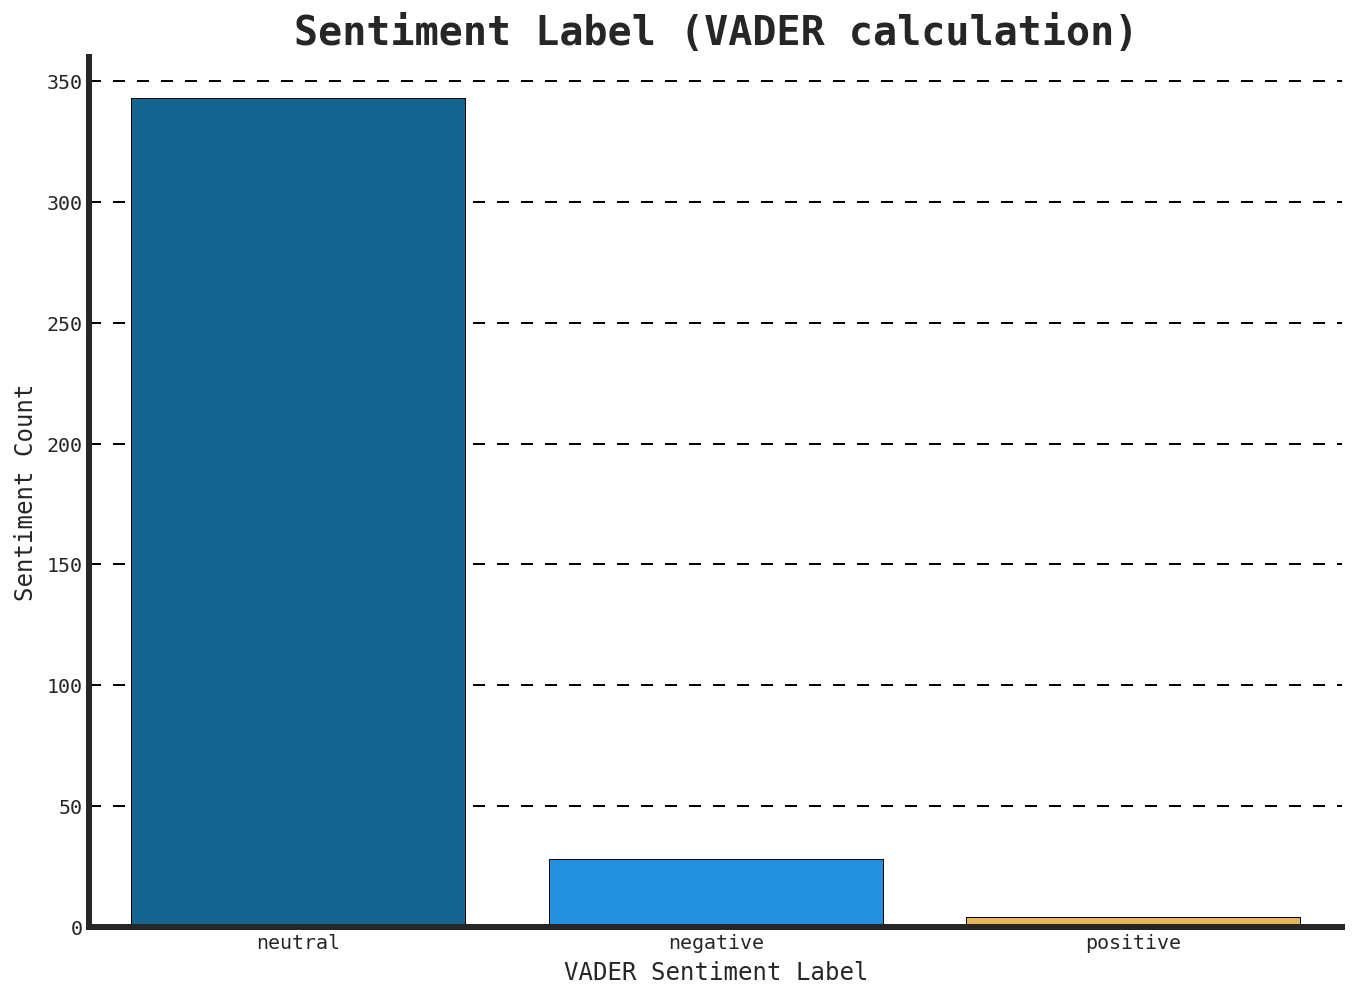

In [158]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(title_df['vader_sentiment'].value_counts().index,
            title_df['vader_sentiment'].value_counts(), edgecolor='black')
ax.set_title("Sentiment Label (VADER calculation)", size=20, fontweight='bold')
ax.set_xlabel("VADER Sentiment Label")
ax.set_ylabel("Sentiment Count")
ax.grid(color='black', linestyle=':', axis='y', zorder=0, dashes=(6, 6))
plt.show();

Visualize NER with SpaCy

In [159]:
# hide
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.7 MB 3.8 MB/s            
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [171]:
import spacy
from spacy import displacy
# from IPython.core.display import display, HTML

rand_title = np.random.randint(0, 381)
text = title_df['title'][rand_title]
# print(text)

nlp = spacy.load('en_core_web_sm')
doc = nlp(text)

# html = displacy.render(doc, style='ent', jupyter=True)
# display(HTML(html))

displacy.render(doc, style='ent')

I've run the above code multiple times and it seems like the visualizer doesn't pick up on some basic names. For now we'll move along. What we can do that might be useful is to apply NER on our headlines and then store the entity types.

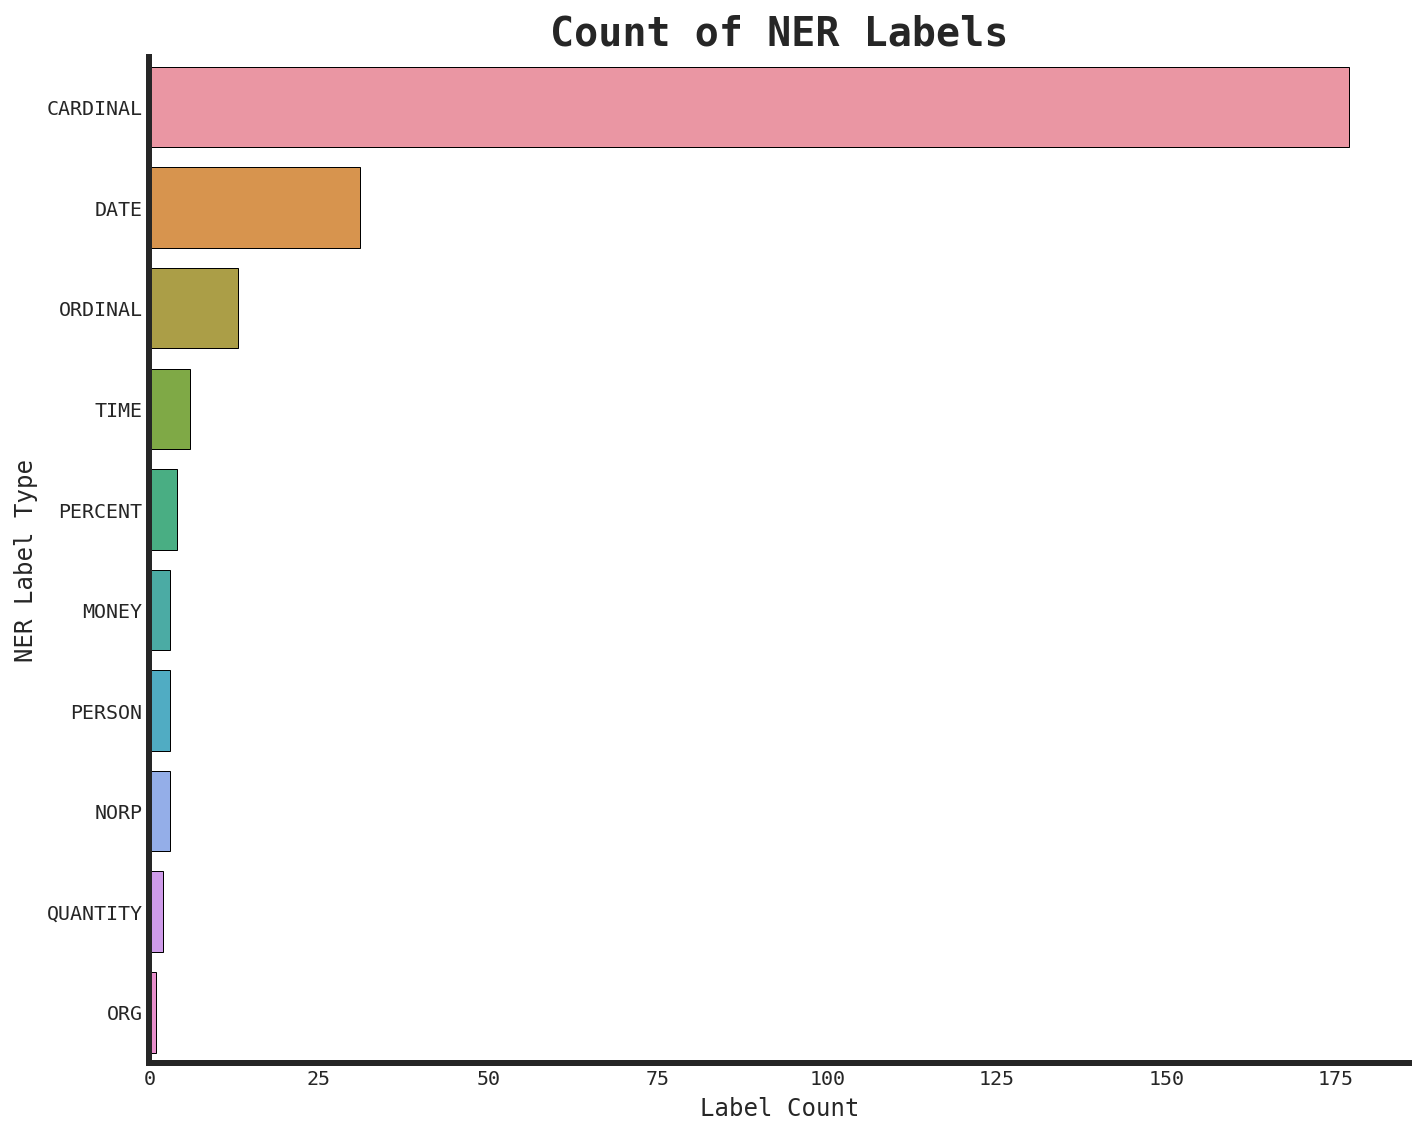

In [173]:
from collections import Counter

def ner_types(text):
    doc = nlp(text)
    return [X.label_ for X in doc.ents]

ent = title_df['title'].apply(lambda x: ner_types(x))
ent = [x for sub in ent for x in sub]

counter = Counter(ent)
count = counter.most_common()

fig, ax = plt.subplots(figsize=(10, 8))
x, y = map(list, zip(*count))
sns.barplot(x=y, y=x, edgecolor='black')
ax.set_title("Count of NER Labels", size=20, fontweight='bold')
ax.set_xlabel("Label Count")
ax.set_ylabel("NER Label Type")
plt.tight_layout()
plt.show();